In [111]:
import os

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import scikit_posthocs as sp
import scipy.stats as stats
from termcolor import colored

In [112]:
cwd = os.getcwd()
benchmark_result_path = os.path.realpath(
  os.path.join(cwd, "../data/realworld-results.csv")
)

print(benchmark_result_path)

/Users/csalih/Developer/bsc-web-benchmark/benchmark/benchmark-analyze/data/realworld-results.csv


In [113]:
# Load the dataset
csv_headers = ["framework", "os", "browser", "metric", "rating", "value"]
df = pd.read_csv(benchmark_result_path, header=None, names=csv_headers)

df['value'] = pd.to_numeric(df['value'], errors='raise')

# Group the data
frameworks = df["framework"].unique()
metrics = df["metric"].unique()
browsers = df["browser"].unique()
operating_systems = df["os"].unique()

df_by_framework = df.groupby("framework")
df_by_metric = df.groupby("metric")

# Display basic info
pd.concat([df.head(5), df.tail(5)])

,framework,os,browser,metric,rating,value
0,realworld-angular,darwin,chromium,TTFB,good,6.3
1,realworld-angular,darwin,chromium,FCP,good,52.0
2,realworld-angular,darwin,chromium,FID,good,1.6
3,realworld-angular,darwin,chromium,LCP,good,80.0
4,realworld-angular,darwin,chromium,TTFB,good,3.6
119995,realworld-vue,win32,webkit,FCP,good,362.0
119996,realworld-vue,win32,webkit,TTFB,good,3.0
119997,realworld-vue,win32,webkit,FCP,good,389.0
119998,realworld-vue,win32,webkit,TTFB,good,3.0
119999,realworld-vue,win32,webkit,FCP,good,395.0


In [114]:
# Validate

# Check if there is sufficient data
if (
  df["framework"].nunique() < 0
  or df["browser"].nunique() < 0
  or df["os"].nunique() < 0
):
  raise Exception(f"Data has insufficient data.")

# Group by all factors and count the number of observations
counts = (
  df.groupby(["framework", "metric", "browser", "os"])
  .size()
  .reset_index(name="count")
)
single_observations = counts[counts["count"] == 1]

if not single_observations.empty:
  print("WARNING: The following groups have only one observation. ANOVA may fail:")
  print(single_observations)
  raise Exception("Consider combining levels or simplifying your model.")

In [115]:
for metric in metrics:
  data = df
  data = data[data.metric.eq(metric)]

  # Group by (browser, os) and compute descriptive statistics
  summary = data.groupby(['browser', 'os'])['value'].describe().map(lambda x: f"{x:0.2f}")

  # Convert to a clean format
  summary.index = [f"{b.capitalize()} ({o.capitalize()})" for b, o in summary.index]

  # Compute total row
  total_row = data['value'].describe().apply("{0:.2f}".format).to_frame().T
  total_row.index = ["Total"]
  summary = pd.concat([summary, total_row])

  # Rename columns for better readability
  summary = summary.drop(columns=['25%'])
  summary = summary.rename(columns={
    'count': 'Count', 'mean': 'Mean', 'std': 'Std',
    'min': 'Min', '50%': '50%', '75%': '75%', 'max': 'Max'
  })

  # Print the final summary
  print(colored("######################################################################", "light_blue"))
  print(colored(f"Results for Metric: {metric}", "light_blue"))
  print(colored("######################################################################", "light_blue"))
  print("")
  display(summary)

######################################################################
Results for Metric: TTFB
######################################################################



,Count,Mean,Std,Min,50%,75%,Max
Chromium (Darwin),4000.00,3.08,0.79,1.60,3.30,3.60,12.30
Chromium (Linux),4000.00,2.08,0.21,1.60,2.00,2.20,5.30
Chromium (Win32),4000.00,5.06,0.59,4.30,5.00,5.20,16.90
Firefox (Darwin),4000.00,7.92,3.91,3.00,7.00,10.00,21.00
Firefox (Linux),4000.00,16.58,8.14,4.00,15.00,18.00,70.00
Firefox (Win32),4000.00,42.64,11.82,11.00,43.00,51.00,113.00
Webkit (Darwin),4000.00,2.55,1.41,1.00,2.00,3.00,45.00
Webkit (Linux),4000.00,1.00,0.10,1.00,1.00,1.00,6.00
Webkit (Win32),4000.00,3.49,1.04,1.00,3.00,4.00,30.00
Total,36000.00,9.38,13.53,1.00,4.00,9.00,113.00


######################################################################
Results for Metric: FCP
######################################################################



,Count,Mean,Std,Min,50%,75%,Max
Chromium (Darwin),4000.00,57.99,9.55,32.00,60.00,64.00,100.00
Chromium (Linux),4000.00,93.39,18.47,59.40,89.00,111.40,244.20
Chromium (Win32),4000.00,104.86,27.15,65.40,104.10,123.93,632.30
Firefox (Darwin),4000.00,83.07,14.06,43.00,85.00,94.00,120.00
Firefox (Linux),4000.00,321.16,50.71,165.00,331.00,355.00,578.00
Firefox (Win32),4000.00,368.07,52.43,199.00,362.00,400.00,1163.00
Webkit (Darwin),4000.00,61.21,10.30,39.00,60.00,71.00,110.00
Webkit (Linux),4000.00,130.55,32.55,84.00,126.00,163.00,435.00
Webkit (Win32),4000.00,294.72,138.08,114.00,279.00,375.00,1333.00
Total,36000.00,168.34,128.29,32.00,104.20,290.00,1333.00


######################################################################
Results for Metric: FID
######################################################################



,Count,Mean,Std,Min,50%,75%,Max
Chromium (Darwin),4000.00,0.73,0.38,0.30,0.60,1.00,2.20
Chromium (Linux),4000.00,1.33,0.58,0.60,1.10,1.70,7.60
Chromium (Win32),4000.00,1.48,0.41,0.80,1.40,1.80,3.70
Firefox (Darwin),4000.00,0.27,0.46,0.00,0.00,1.00,2.00
Firefox (Linux),4000.00,0.97,0.51,0.00,1.00,1.00,4.00
Firefox (Win32),4000.00,1.09,0.49,0.00,1.00,1.00,4.00
Total,24000.00,0.98,0.62,0.00,1.00,1.20,7.60


######################################################################
Results for Metric: LCP
######################################################################



,Count,Mean,Std,Min,50%,75%,Max
Chromium (Darwin),4000.00,70.79,8.80,52.00,72.00,76.00,128.00
Chromium (Linux),4000.00,164.28,44.52,93.70,152.35,188.00,495.10
Chromium (Win32),4000.00,163.67,55.22,92.10,167.85,216.05,731.10
Firefox (Darwin),4000.00,88.25,15.33,46.00,88.00,102.00,131.00
Firefox (Linux),4000.00,341.95,52.66,199.00,350.00,378.00,588.00
Firefox (Win32),4000.00,398.48,65.24,200.00,398.00,440.00,1173.00
Total,24000.00,204.57,131.39,46.00,152.50,333.00,1173.00


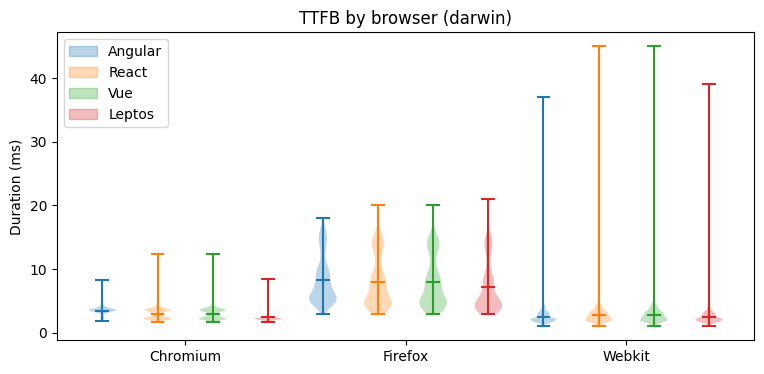

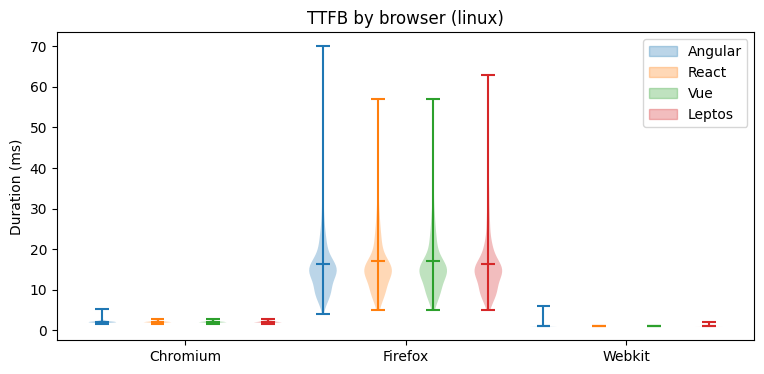

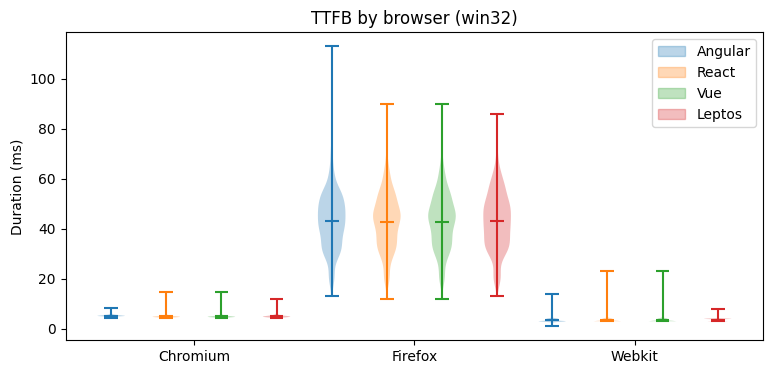

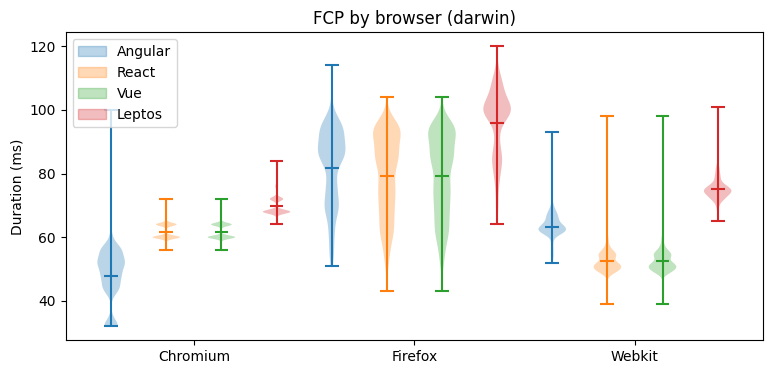

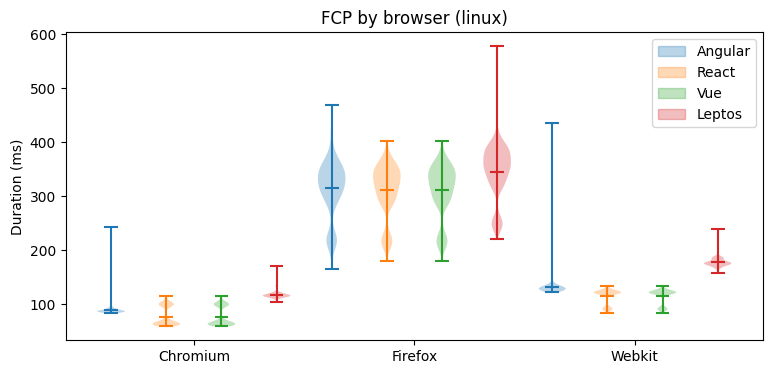

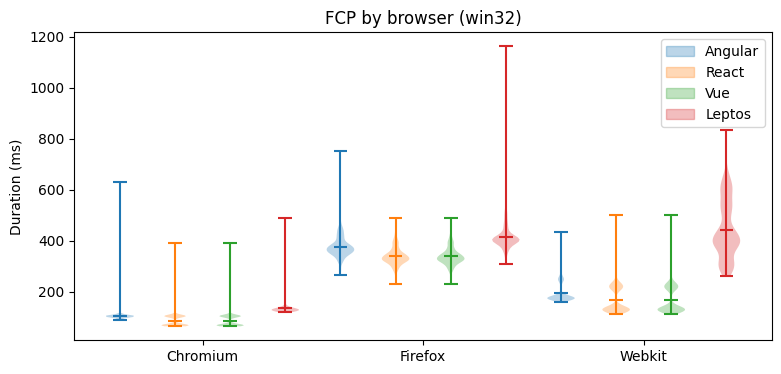

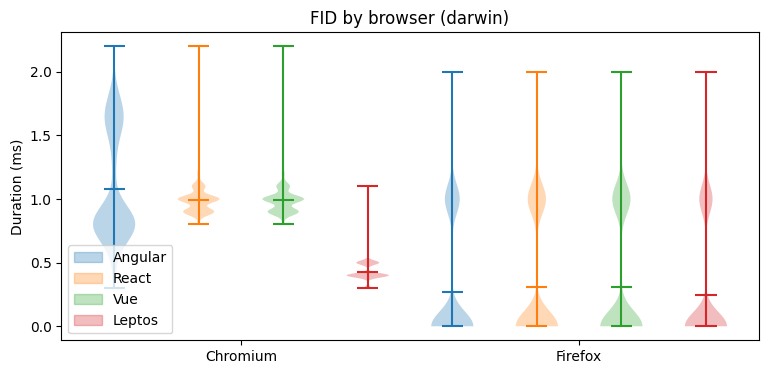

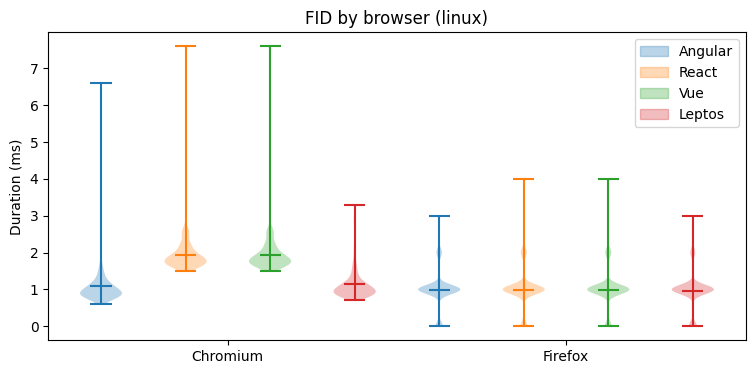

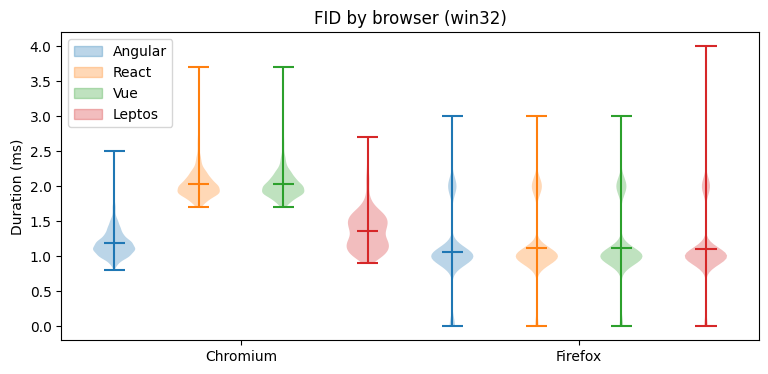

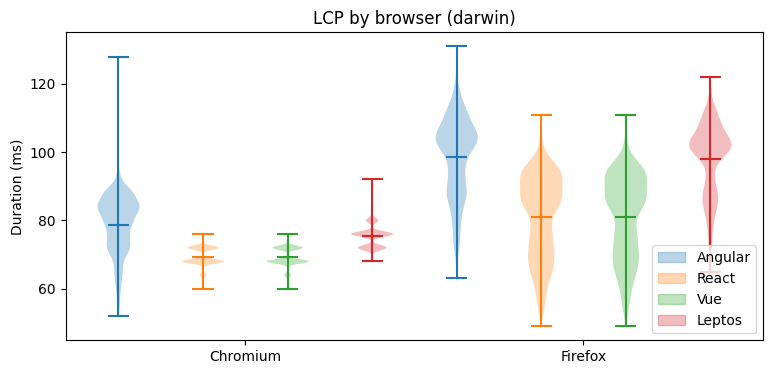

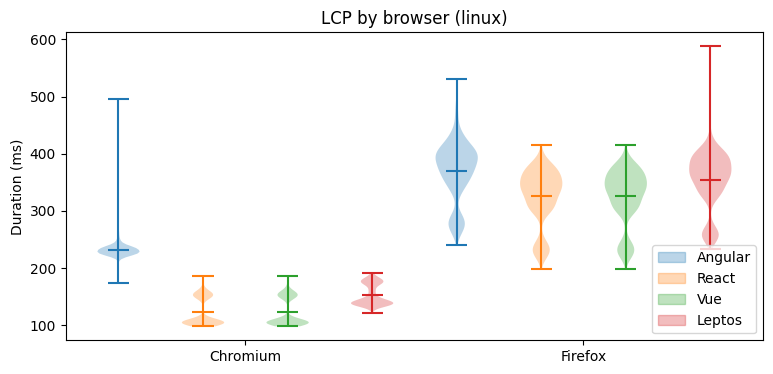

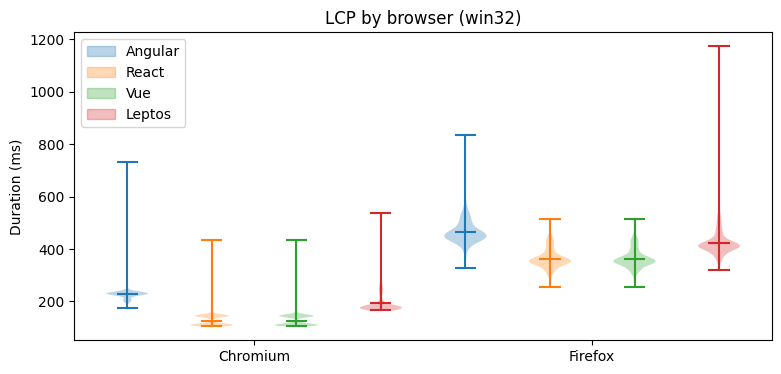

In [106]:
for metric in metrics:
  for idx_os, os in enumerate(operating_systems):
    labels = []


    def add_label(violin, label):
      color = violin["bodies"][0].get_facecolor().flatten()
      labels.append((mpatches.Patch(color=color), label))


    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))

    subset = df
    subset = subset[subset.os.eq(os)]
    subset = subset[subset.metric.eq(metric)]

    positions = [[1, 5, 9], [2, 6, 10], [3, 7, 11], [4, 8, 12]]

    # Conduit Angular
    data = subset[subset.framework.eq("realworld-angular")]
    durations = [group['value'] for _, group in data.groupby(['browser'])]
    rects = ax.violinplot(durations, positions[0][:len(durations)], showmeans=True, showmedians=False)
    add_label(rects, "Angular")

    # Conduit React
    data = subset[subset.framework.eq("realworld-react")]
    durations = [group['value'] for _, group in data.groupby(['browser'])]
    rects = ax.violinplot(durations, positions[1][:len(durations)], showmeans=True, showmedians=False)
    add_label(rects, "React")

    data = subset[subset.framework.eq("realworld-react")]
    durations = [group['value'] for _, group in data.groupby(['browser'])]
    rects = ax.violinplot(durations, positions[2][:len(durations)], showmeans=True, showmedians=False)
    add_label(rects, "Vue")

    data = subset[subset.framework.eq("realworld-leptos")]
    durations = [group['value'] for _, group in data.groupby(['browser'])]
    rects = ax.violinplot(durations, positions[3][:len(durations)], showmeans=True, showmedians=False)
    add_label(rects, "Leptos")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_title(f'{metric} by browser ({os})')
    ax.set_ylabel('Duration (ms)')
    x_labels = data["browser"].str.title().unique()
    ax.set_xticks([2.5, 6.5, 10.5][:len(x_labels)], x_labels)

    # Legend
    ax.legend(*zip(*labels))
    #plt.legend(*zip(*labels), loc='upper right')

    plt.show()
    ax.set_title("")
    fig.savefig(f"output/{metric.lower()}_{os}.pdf")

In [110]:
# Store Kruskal-Wallis results
kruskal_results = []
posthoc_results_kruskal = {}
friedman_results = []
posthoc_results_friedman = {}
mean_ranks = {}
mean_ranks_browser = {}

# 1️⃣ Kruskal-Wallis Test & Dunn's Post Hoc if Significant
for metric in metrics:
  subset = df[df['metric'] == metric]
  groups = [subset[subset['framework'] == fw]['value'].values for fw in subset['framework'].unique()]

  # Kruskal-Wallis Test
  stat, p = stats.kruskal(*groups)
  kruskal_results.append({'Metric': metric, 'H-stat': stat, 'p-value': p})

  # If significant, perform Dunn’s post hoc test
  if p < 0.05:
    posthoc = sp.posthoc_dunn(subset, val_col='value', group_col='framework')
    posthoc_results_kruskal[metric] = posthoc

# Step 2: Check Browser Impact Using Friedman Test
df_agg = df.groupby(['framework', 'browser', 'metric'])['value'].mean().reset_index()
for metric in metrics:
  subset = df_agg[df_agg['metric'] == metric]
  pivot_table = subset.pivot(index='framework', columns='browser', values='value')

  # Ensure enough data
  if pivot_table.shape[1] == 2:
    group1 = subset[(subset['browser'] == "chromium")]['value']
    group2 = subset[(subset['browser'] == "firefox")]['value']

    stat, p = stats.wilcoxon(group1, group2, zero_method='wilcox')
    print(f"Wilcoxon test between chromium and firefox for {metric}: W={stat:.4f}, p={p:.4f}")

  if pivot_table.shape[1] >= 3:
    stat, p = stats.friedmanchisquare(*pivot_table.T.values)
    friedman_results.append({'Metric': metric, 'F-stat': stat, 'p-value': p})

    # If significant, perform Nemenyi post hoc test
    if p < 0.05:
      posthoc = sp.posthoc_nemenyi_friedman(pivot_table)
      posthoc_results_friedman[metric] = posthoc

  # Step 3: Compute Mean Rank Differences for Ranking Frameworks
  mean_ranks_browser[metric] = pivot_table.rank(axis=1, method='average').mean().sort_values()

# 3️⃣ Compute Mean Rank Differences for Ranking Frameworks
mean_ranks = df.groupby(['framework', 'metric'])['value'].mean().reset_index()
mean_ranks['rank'] = mean_ranks.groupby('metric')['value'].rank(method='average')

# Convert results to DataFrames
kruskal_df = pd.DataFrame(kruskal_results)
friedman_df = pd.DataFrame(friedman_results)
mean_ranks_df = pd.DataFrame(mean_ranks)
mean_ranks_browser_df = pd.DataFrame(mean_ranks_browser)

# 📌 Print Results
print("\n=== Kruskal-Wallis Test Results ===")
print(kruskal_df)

print("\n=== Mean Rank Comparison ===")
print(mean_ranks_df)

print("\n=== Friedman Test Results (Browser Impact) ===")
print(friedman_df)

# 📌 Post Hoc Results
print("\n=== Dunn’s Post Hoc (For Significant Kruskal Tests) ===")
for metric, result in posthoc_results_kruskal.items():
  print(f"\n📌 Dunn’s Test for Metric: {metric}")
  display(result)
  display(result < 0.05)

print("\n=== Nemenyi Post Hoc (For Significant Friedman Tests) ===")
for metric, result in posthoc_results_friedman.items():
  print(f"\n📌 Nemenyi Test for Metric: {metric}")
  print(result)

print("\n=== Mean Rank Comparison Browser ===")
display(mean_ranks_browser_df)

Wilcoxon test between chromium and firefox for FID: W=0.0000, p=0.1250
Wilcoxon test between chromium and firefox for LCP: W=0.0000, p=0.1250

=== Kruskal-Wallis Test Results ===
  Metric       H-stat        p-value
0   TTFB    37.834506   3.063941e-08
1    FCP  1968.316766   0.000000e+00
2    FID  1130.299957  9.714120e-245
3    LCP  1348.502454  4.401496e-292

=== Mean Rank Comparison ===
            framework metric       value  rank
0   realworld-angular    FCP  156.208656   2.0
1   realworld-angular    FID    0.947967   3.0
2   realworld-angular    LCP  245.410667   4.0
3   realworld-angular   TTFB    9.496544   4.0
4    realworld-leptos    FCP  208.486867   4.0
5    realworld-leptos    FID    0.872983   2.0
6    realworld-leptos    LCP  216.330183   3.0
7    realworld-leptos   TTFB    9.240567   1.0
8     realworld-react    FCP  143.359722   1.0
9     realworld-react    FID    1.234150   4.0
10    realworld-react    LCP  181.271100   2.0
11    realworld-react   TTFB    9.434767  

,realworld-angular,realworld-leptos,realworld-react,realworld-vue
realworld-angular,1.000000e+00,2.328645e-09,0.002114,0.068881
realworld-leptos,2.328645e-09,1.000000e+00,0.003740,0.000033
realworld-react,2.113753e-03,3.740208e-03,1.000000,0.209636
realworld-vue,6.888127e-02,3.269303e-05,0.209636,1.000000


,realworld-angular,realworld-leptos,realworld-react,realworld-vue
realworld-angular,False,True,True,False
realworld-leptos,True,False,True,True
realworld-react,True,True,False,False
realworld-vue,False,True,False,False



📌 Dunn’s Test for Metric: FCP


,realworld-angular,realworld-leptos,realworld-react,realworld-vue
realworld-angular,1.000000e+00,9.936206e-184,1.509840e-30,1.782410e-11
realworld-leptos,9.936206e-184,1.000000e+00,0.000000e+00,4.953911e-278
realworld-react,1.509840e-30,0.000000e+00,1.000000e+00,1.883663e-06
realworld-vue,1.782410e-11,4.953911e-278,1.883663e-06,1.000000e+00


,realworld-angular,realworld-leptos,realworld-react,realworld-vue
realworld-angular,False,True,True,True
realworld-leptos,True,False,True,True
realworld-react,True,True,False,True
realworld-vue,True,True,True,False



📌 Dunn’s Test for Metric: FID


,realworld-angular,realworld-leptos,realworld-react,realworld-vue
realworld-angular,1.000000e+00,2.005052e-09,3.775252e-108,1.692527e-14
realworld-leptos,2.005052e-09,1.000000e+00,1.320962e-173,9.399997e-02
realworld-react,3.775252e-108,1.320962e-173,1.000000e+00,1.141490e-194
realworld-vue,1.692527e-14,9.399997e-02,1.141490e-194,1.000000e+00


,realworld-angular,realworld-leptos,realworld-react,realworld-vue
realworld-angular,False,True,True,True
realworld-leptos,True,False,True,False
realworld-react,True,True,False,True
realworld-vue,True,False,True,False



📌 Dunn’s Test for Metric: LCP


,realworld-angular,realworld-leptos,realworld-react,realworld-vue
realworld-angular,1.000000e+00,1.292924e-20,3.251275e-161,1.081328e-224
realworld-leptos,1.292924e-20,1.000000e+00,1.813196e-70,5.439222e-114
realworld-react,3.251275e-161,1.813196e-70,1.000000e+00,7.641175e-07
realworld-vue,1.081328e-224,5.439222e-114,7.641175e-07,1.000000e+00


,realworld-angular,realworld-leptos,realworld-react,realworld-vue
realworld-angular,False,True,True,True
realworld-leptos,True,False,True,True
realworld-react,True,True,False,True
realworld-vue,True,True,True,False



=== Nemenyi Post Hoc (For Significant Friedman Tests) ===

📌 Nemenyi Test for Metric: TTFB
          chromium   firefox    webkit
chromium  1.000000  0.333499  0.333499
firefox   0.333499  1.000000  0.012988
webkit    0.333499  0.012988  1.000000

📌 Nemenyi Test for Metric: FCP
          chromium   firefox    webkit
chromium  1.000000  0.012988  0.333499
firefox   0.012988  1.000000  0.333499
webkit    0.333499  0.333499  1.000000

=== Mean Rank Comparison Browser ===


,TTFB,FCP,FID,LCP
browser,,,,
chromium,2.0,1.0,2.0,1.0
firefox,3.0,3.0,1.0,2.0
webkit,1.0,2.0,NaN,NaN


In [116]:
# Compute mean-based ranking
ranked_frameworks = df.groupby(['metric', 'framework'])['value'].mean().reset_index()
ranked_frameworks['rank'] = ranked_frameworks.groupby('metric')['value'].rank(method='dense', ascending=True)

# Create final ranking table
rank_table = ranked_frameworks.pivot(index='framework', columns='metric', values='rank')
# Convert ranks to integers
rank_table['mean_rank'] = rank_table.mean(axis=1)
rank_table = rank_table.sort_values('mean_rank')

display(rank_table)


metric,FCP,FID,LCP,TTFB,mean_rank
framework,,,,,
realworld-vue,3.0,1.0,1.0,2.0,1.75
realworld-leptos,4.0,2.0,3.0,1.0,2.50
realworld-react,1.0,4.0,2.0,3.0,2.50
realworld-angular,2.0,3.0,4.0,4.0,3.25
